Import Packages
---
Github:  https://github.com/jeffjay88/Climate_Indices

In [7]:
from distributed import Client
client = Client(n_workers=4, threads_per_worker=1, memory_limit='1GB') 

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt


%matplotlib inline

Load Data
---

In [9]:
da_data = xr.open_dataset('cru_ts4.03.1901.2018.pre.dat.nc')
ds_RR = da_data['pre']
ds_RR_WestAfrica = ds_RR.sel(lon=slice(-20,15), lat=slice(0,15),time=slice('2015','2018'))

SPI Function (self-defined)
---

In [10]:
#Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    ds_mu = ds_ma.mean(dimension)
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

Perform SPI computation on Data
---

In [11]:
i=3
da_data['spi_3'] = spi(ds_RR_WestAfrica,i,'time')[9]

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:56262 remote=tcp://127.0.0.1:56190>


In [12]:
da_data

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1416)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Data variables:
    pre      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
    spi_3    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.03 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 1905011326. Data generated from:pre.1905011321.dtb
    history:      Thu  2 May 2019 06:31:34 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

Visualization of SPI
---

(-20, 15)

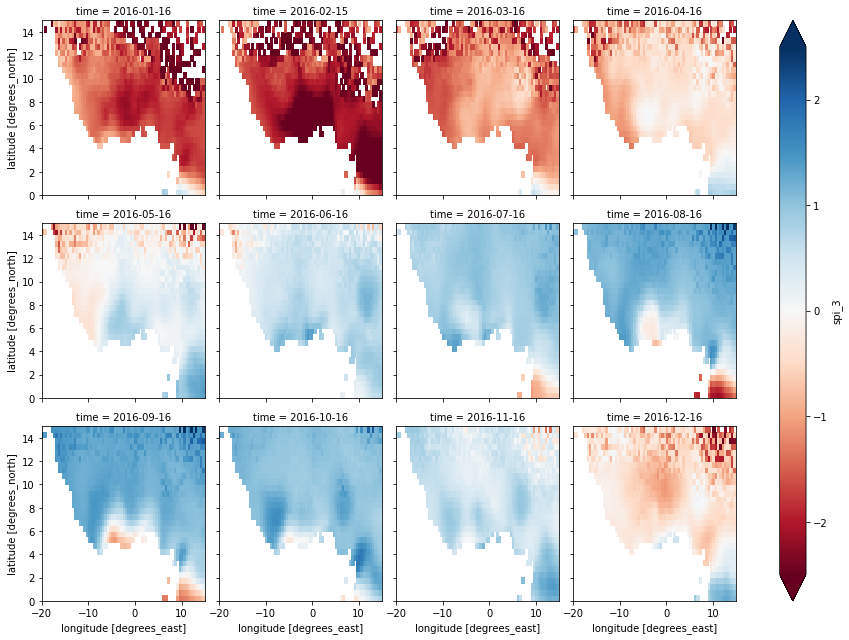

In [39]:
da_data['spi_3'].sel(time='2016').plot(cmap='RdBu', col='time', col_wrap=4, vmin=-2.5, vmax=2.5)
plt.ylim(0,15)
plt.xlim(-20,15)